In [1]:
import os
import cv2
import random
import torch
import numpy as np
from PIL import Image
from utils.DiffusionUtils import DiffusionUtils
from utils.TemplateManager import TemplateManager

from ptp.AttentionControls import AttentionStore
from ptp.ptp_utils import text2image_ldm_stable, view_images
from ptp.attn_utils import aggregate_attention, show_cross_attention, show_self_attention_comp

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [2]:
def otsu_thresholding(image: np.ndarray) -> np.ndarray:
    """
    Apply Otsu's thresholding to a color image by converting it to grayscale.
    Parameters: image (np.ndarray): Input color image of shape (H, W, C). 
    Returns: np.ndarray: Binary thresholded image.
    """
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return np.expand_dims(binary_image, axis=2)

def get_image_latent(img_path):
    image = Image.open(img_path).resize((512, 512))
    image = np.expand_dims(image, axis=0)
    image_latent = torch.tensor(DiffusionUtils.image2latent(image[:,:,:,:3]), dtype=torch.float16).to(DiffusionUtils.device)
    return image_latent

In [3]:
dataset_name = "test"
exp_name = "20250505_instree_1_image"
exp_path = f"/home/jack/Code/Research/instree_analysis/experiments/{dataset_name}/{exp_name}"
cpt_name = "dog1"

img_dataset_name = "dog_backpack_1_image"
origin_img_path = f"/home/jack/Code/Research/instree_analysis/experiment_data/{img_dataset_name}/{cpt_name}/v0/"
img_names = os.listdir(origin_img_path)
if ".DS_Store" in img_names:
    img_names.remove(".DS_Store")
origin_img_path += random.choice(img_names)
print(f"origin_img_path: {origin_img_path}")

concept_path = f"{exp_path}/outputs/{cpt_name}/v0/learned_embeds.bin"
# concept_path = f"{exp_path}/outputs/{cpt_name}/v0/v0_seed0/learned_embeds.bin"
concepts = torch.load(concept_path)
DiffusionUtils.reset_vocab()
DiffusionUtils.add_new_vocab('<*>', concepts['<*>'])
DiffusionUtils.add_new_vocab('<&>', concepts['<&>'])

origin_img_path: /home/jack/Code/Research/instree_analysis/experiment_data/dog_backpack_1_image/dog1/v0/00 copy.jpg
Vocabulary has been reset.
Current vocab size:  49408
New token added:  <*>
Current vocab size:  49409
All new tokens:  {'<*>': 49408}
New token added:  <&>
Current vocab size:  49410
All new tokens:  {'<*>': 49408, '<&>': 49409}


In [4]:
# paper_concept_path = "/home/jack/Code/Research/instree_main/assets/paper_tokens.bin"
# paper_concepts = torch.load(paper_concept_path)
# print(paper_concepts.keys())
# DiffusionUtils.reset_vocab()

# for cpt in paper_concepts.keys():
#     DiffusionUtils.add_new_vocab(f"<{cpt}_v1>", paper_concepts[cpt][f"<{cpt}_v1>"])
#     DiffusionUtils.add_new_vocab(f"<{cpt}_v2>", paper_concepts[cpt][f"<{cpt}_v2>"])

In [5]:
# cpt_name = 'D_backpack_dog'
# origin_img_path = f"/home/jack/Code/Research/instree_analysis/experiment_data/{dataset_name}/{exp_name}/{cpt_name}/v0/"
# img_names = os.listdir(origin_img_path)
# if ".DS_Store" in img_names:
#     img_names.remove(".DS_Store")
# origin_img_path += random.choice(img_names)
# print(f"origin_img_path: {origin_img_path}")

In [6]:
def analyze_attention_map(prompt, image_path=None, mode="cross", seed=0):
    torch.manual_seed(seed)
    controller = AttentionStore()
    latent = None if image_path is None else get_image_latent(image_path)
    step = 25 if latent is None else 1

    images, x_t = text2image_ldm_stable(
        DiffusionUtils.pipe, 
        [prompt],
        controller, 
        latent=latent, 
        num_inference_steps=step, guidance_scale=7.5, 
        generator=None, low_resource=False)
    view_images(images)
    s = 1

    result = {}
    if mode == "cross":
        attn_map_8, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, ["", prompt], controller, res=8, from_where=("mid",), select=s)
        attn_map_16, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, ["", prompt], controller, res=16, from_where=("up", "down"), select=s)
        attn_map_32, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, ["", prompt], controller, res=32, from_where=("up", "down"), select=s)
        attn_map_64, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, ["", prompt], controller, res=64, from_where=("up", "down"), select=s)
    elif mode == "self":
        attn_map_8, text = show_self_attention_comp(["", prompt], controller, res=8, from_where=("mid",), select=s)
        attn_map_16, text = show_self_attention_comp(["", prompt], controller, res=16, from_where=("up", "down"), select=s)
        attn_map_32, text = show_self_attention_comp(["", prompt], controller, res=32, from_where=("up", "down"), select=s)
        attn_map_64, text = show_self_attention_comp(["", prompt], controller, res=64, from_where=("up", "down"), select=s)
    else:
        raise ValueError("Invalid mode. Choose either 'cross' or 'self'.")
    
    result["attn_8"] = attn_map_8
    result["attn_16"] = attn_map_16
    result["attn_32"] = attn_map_32
    result["attn_64"] = attn_map_64
    result["text"] = text
    result["image"] = images[0]
    
    controller.reset()
    return result

  0%|          | 0/26 [00:00<?, ?it/s]

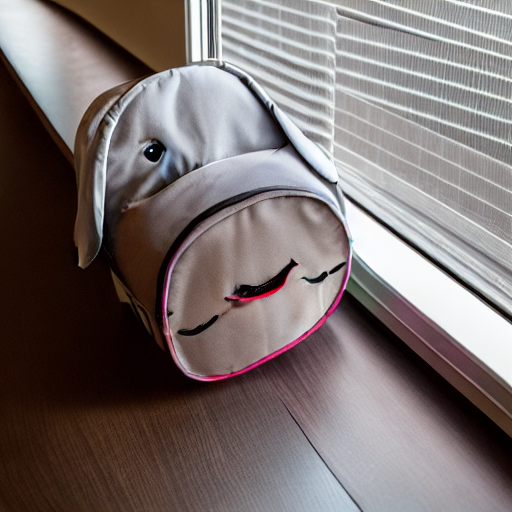

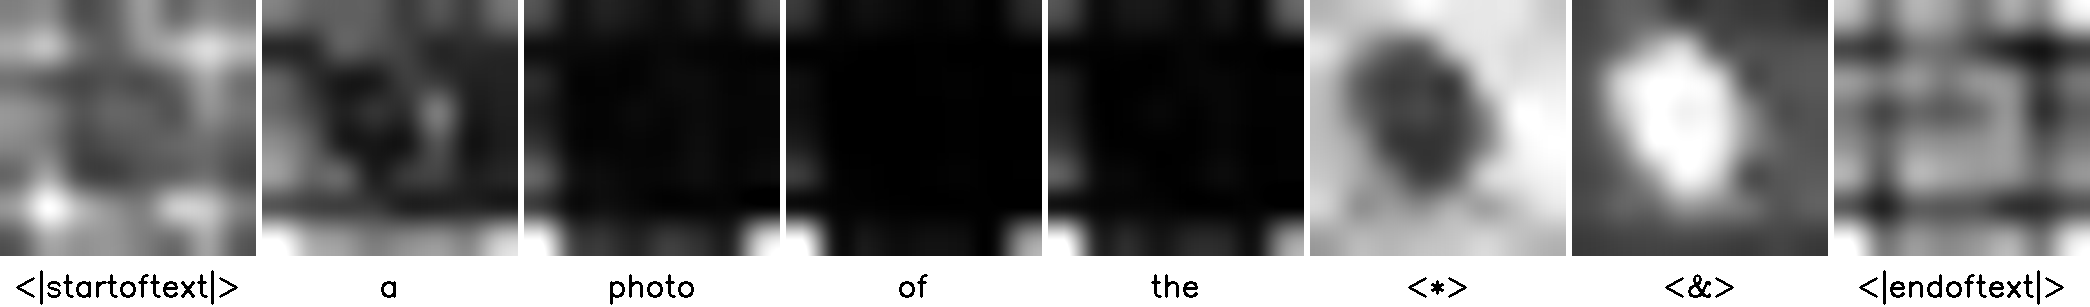

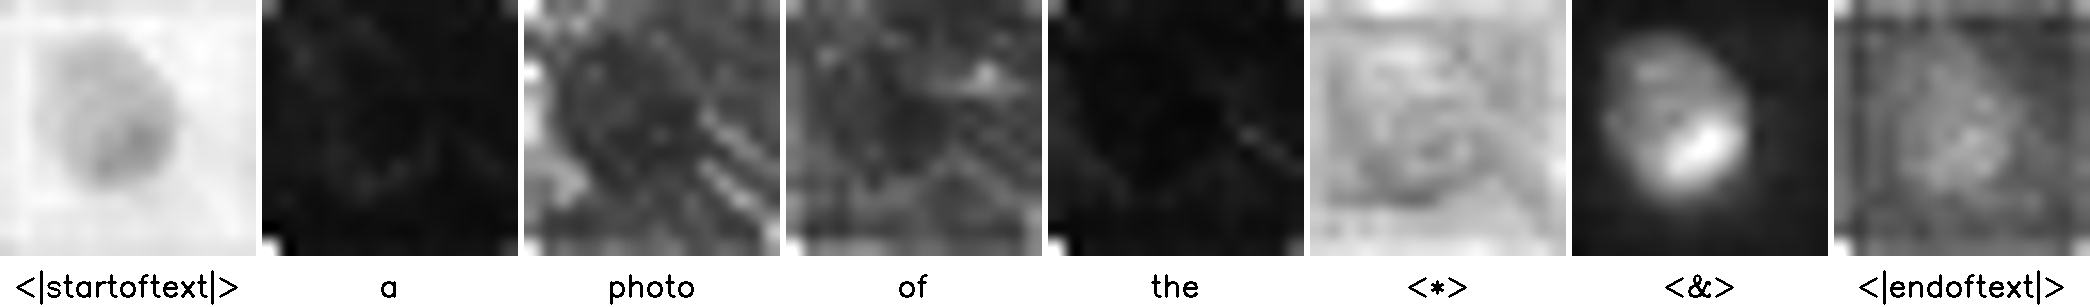

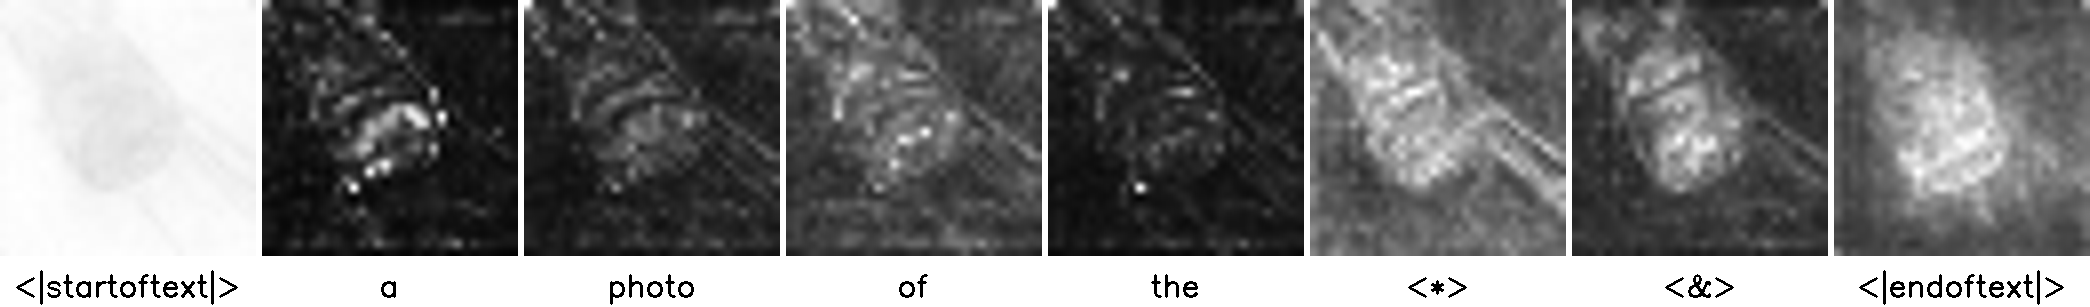

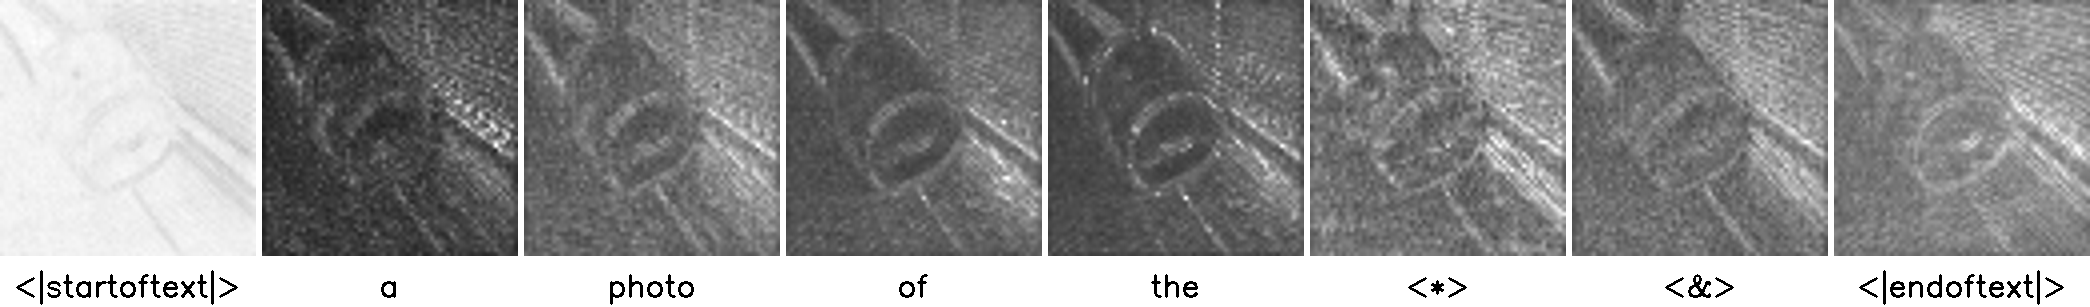

In [7]:
prompt = TemplateManager.get_random_template("IMG").format("<*> <&>")
result = analyze_attention_map(prompt)

In [8]:
get_image_latent(origin_img_path).shape

torch.Size([1, 4, 64, 64])

  0%|          | 0/1 [00:00<?, ?it/s]

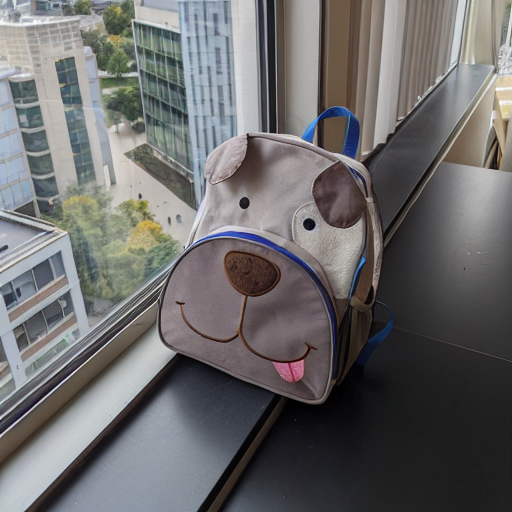

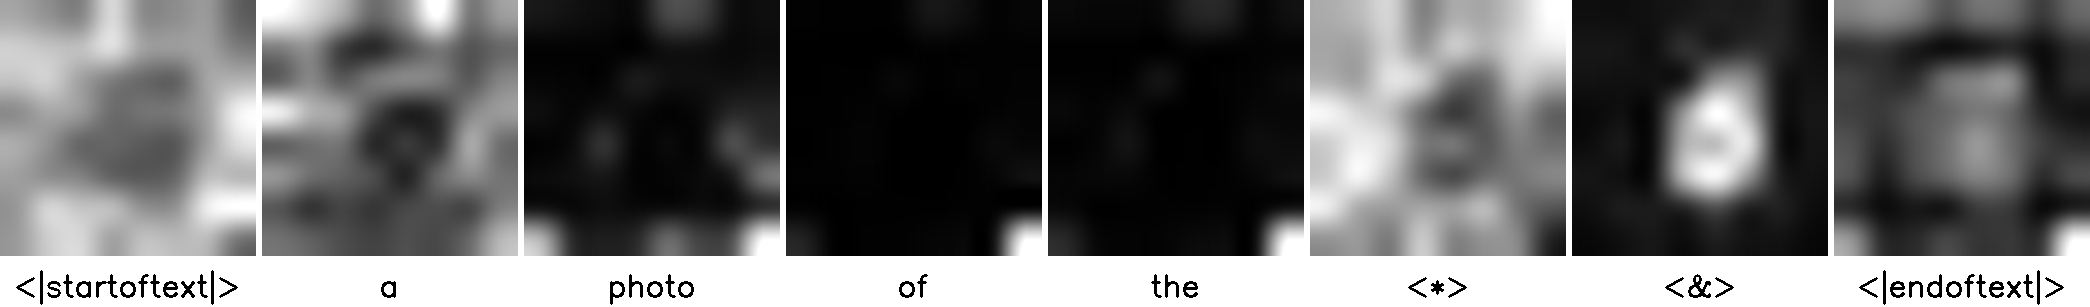

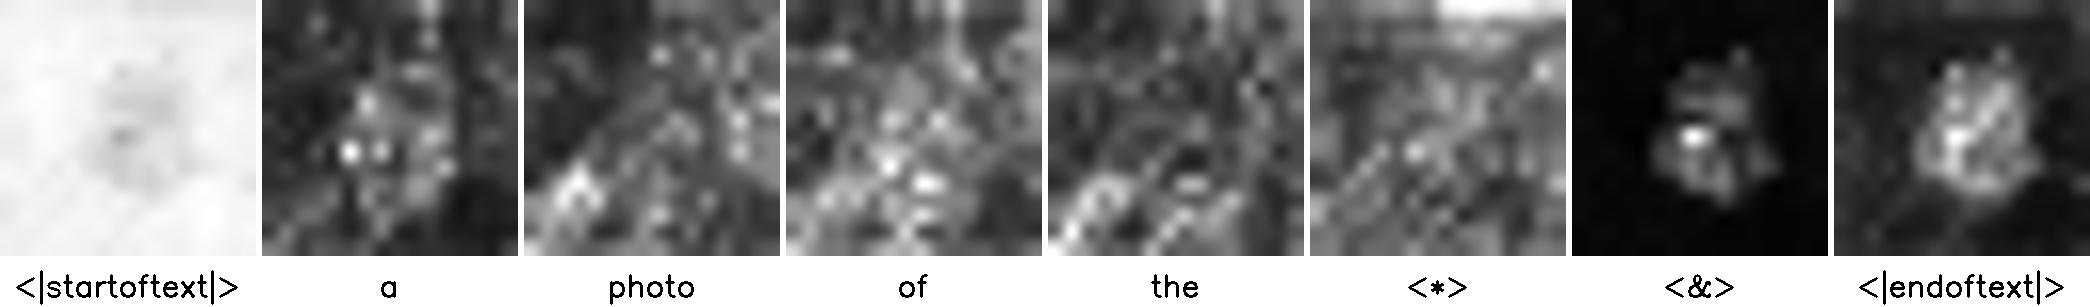

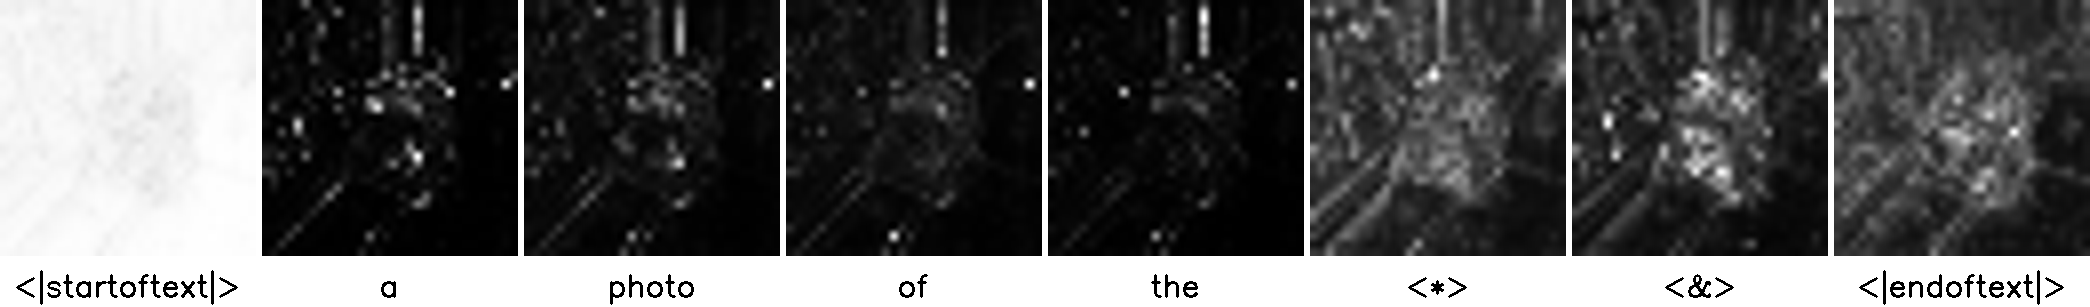

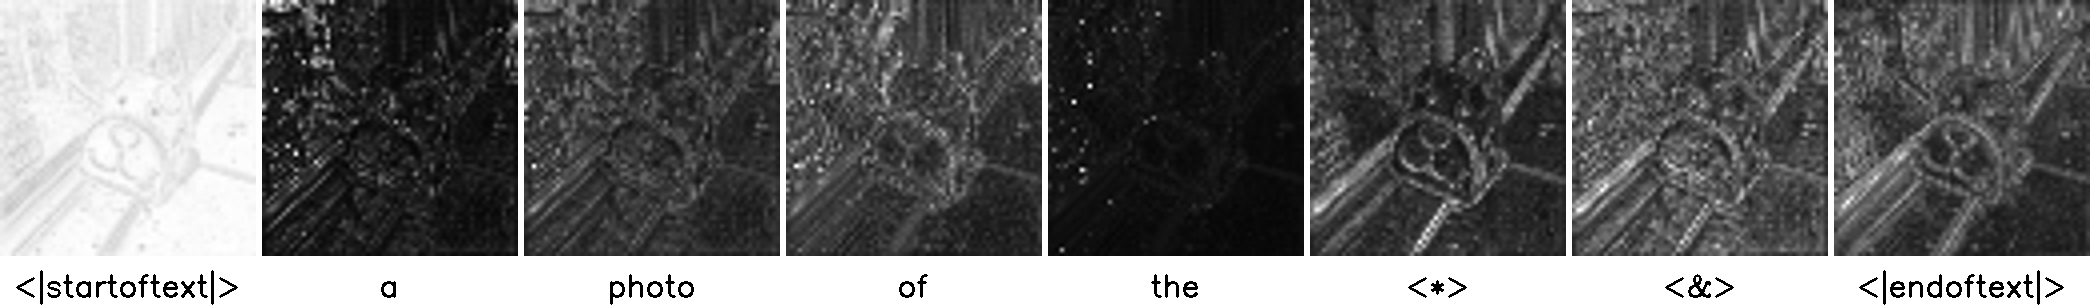

In [9]:
prompt = TemplateManager.get_random_template("IMG")
prompt = "a photo of the {}".format("<*> <&>")
# prompt = "a photo of the {}".format("building dog")
result = analyze_attention_map(prompt, origin_img_path)

['<|startoftext|>', 'a', 'photo', 'of', 'the', '<*>', '<&>', '<|endoftext|>']


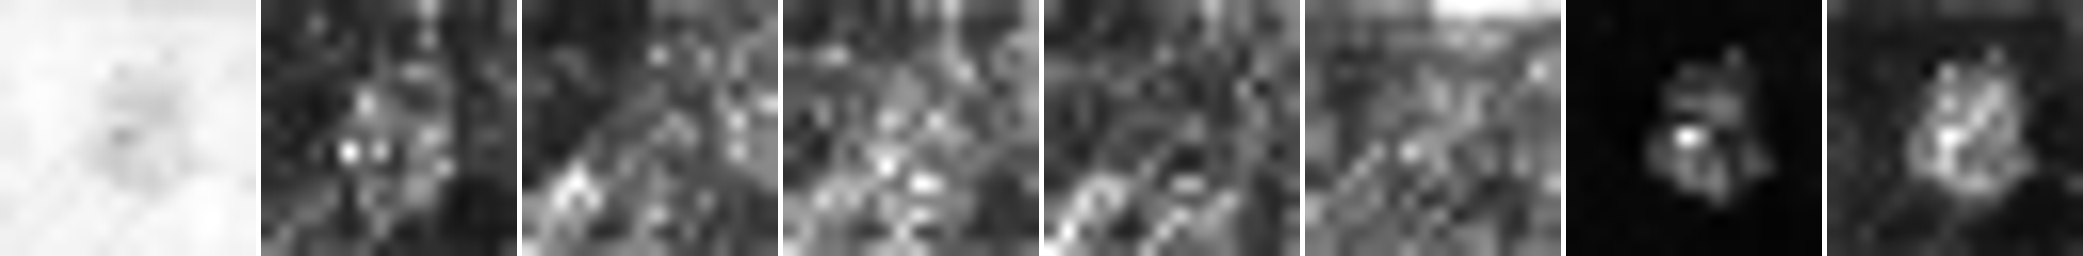

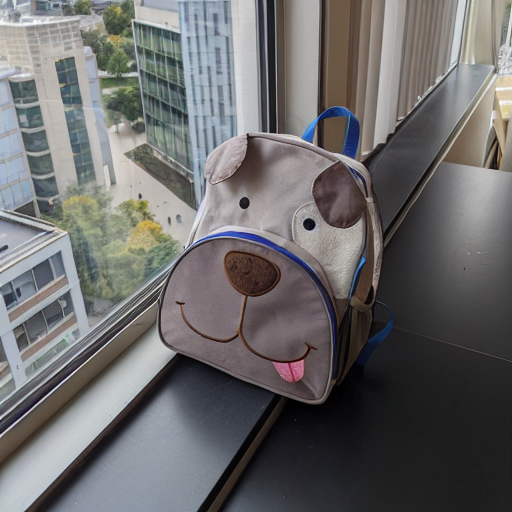

In [69]:
print(result['text'])
view_images(result["attn_16"])
view_images(result["image"])

In [70]:
text = result['text']
idx_v1 = text.index("<*>")
idx_v2 = text.index("<&>")

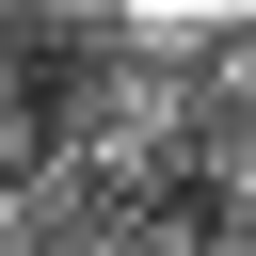

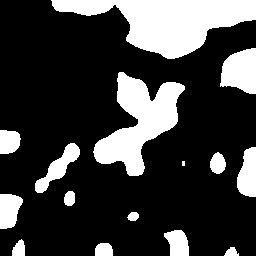

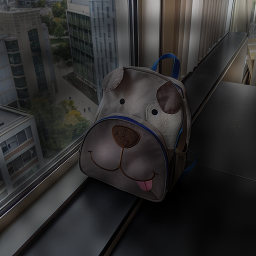

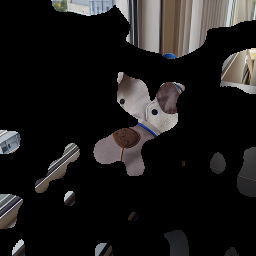

In [72]:
attn_mask = result['attn_16'][idx_v1]
otsu_mask = otsu_thresholding(attn_mask)
resize_origin_img = cv2.resize(result['image'], (256, 256), interpolation=cv2.INTER_CUBIC)

view_images(attn_mask)
view_images(otsu_mask)
view_images(attn_mask / 255 * resize_origin_img)
view_images(otsu_mask / 255 * resize_origin_img)